# AIMS OF THE PROJECT:
## - Top Stock Mentions Today (Tickers), Last 2 days, 5 days, 7 Days, Custom number. Provide it in the list or barchart
## - Print out Comments that mentioned these tickers or just for one ticker
## - Provide visualisation in form of a graph
## - Create a Jupyter Notebook tool with buttons that allows non coder to do such tasks.


In [184]:
from datetime import datetime, date, time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# So that the matplotlib graphs are displayed immediately, instead of
# generating a matplotlib object
%matplotlib inline

import json
import praw
import requests

import jupyter

from praw.models import MoreComments

In [185]:
# Checking the current working directory path
import os
print(os.getcwd())

/Users/nikitaizmailov/Desktop/reddit_analyser


In [186]:
# Jupyter settings for optimizing the output to see without restrictions on view limit
jupyter.textOutputLimit = 0

In [187]:
# Reading JSON file with credentials to access Reddit API Wrapper
creds = 'client_secrets.json'

with open(creds) as f:
    data_creds = json.load(f)

data_creds

{'client_id': 'nF4p5qngjvuOVA',
 'client_secret': '7JiwpJlD8sHhfKJRegj_0li7Wzy6IA',
 'user_agent': 'script by u/TallReplacement229',
 'redirect_uri': 'http://localhost:8080',
 'refresh_token': '378272811181-SQqMoEgWQh8Fz9AQZa_UIN3HBS_Nbg'}

In [473]:
# Creating an instance from Reddit class to interact with Reddit API

reddit = praw.Reddit(
    client_id=data_creds['client_id'],
    client_secret=data_creds['client_secret'],
    user_agent=data_creds['user_agent'],
    redirect_uri=data_creds['redirect_uri'],
    refresh_token=data_creds['refresh_token'],
    check_for_async=False
)

In [189]:
# Remaining api request limits left
# Note, that the values are empty until you've actually issues a command that results in a network request.
reddit.auth.limits

{'remaining': None, 'reset_timestamp': None, 'used': None}

In [190]:
# Choosing a subreddit to analyse
subr = 'wallstreetbets'

# initialising an instance of this class for subreddit
subreddit = reddit.subreddit(subr)

In [191]:
subreddit.title

'wallstreetbets'

In [192]:
# Data storage: Storing all needed attributes of submission object then parsing into the pandas df
submission_posts = {}

In [193]:
# Current Hot Submissions on Reddit group
submissions = subreddit.hot(limit=100)
for number, submission in enumerate(submissions):
    print('%d) submission: %s' % (number, submission.title))
    # saving the submission attributes in the dictionary for later use
    submission_posts[number] = [submission.id, submission.title, submission.author, 
                                submission.score, submission.permalink, submission.num_comments] 

0) submission: Daily Discussion Thread for July 16, 2021
1) submission: Daily Popular Tickers Thread for July 16, 2021 - AMC | GME | AAPL
2) submission: These meme stock guys are a totally different breed
3) submission: We're helping
4) submission: Housing crash is definitely coming and I will tell you exactly when
5) submission: My WSB experience so far
6) submission: You guys are making money?
7) submission: The Market Won’t Crash Any Time Soon Because The Crash Is Already Priced In
8) submission: So you’re telling me there’s a chance?
9) submission: Live look at my portfolio right now
10) submission: CRSR : Reasons why it will go up and touch the moon 🚀🌕 (Elgato)
11) submission: BlackBerry will host a virtual fireside chat to discuss moon opportunity.
12) submission: Real footage of me getting ready to trade every morning
13) submission: Update: Tripled down on my MMAT position. Half a million in. This is the way. 😎
14) submission: For my GME Bull's! A closer look at Gamma Exposure


In [197]:
# Creating a DataFrame to store Submissions data from the subreddit selected
df = pd.DataFrame.from_dict(data=submission_posts, 
                            orient='index', 
                            columns=['submission_id', 'submission_title', 'author', 'score', 'link', 'num_comments'])
df['link'] = 'reddit.com' + df['link'].astype(str)
df

,submission_id,submission_title,author,score,link,num_comments
0,oldt8j,"Daily Discussion Thread for July 16, 2021",OPINION_IS_UNPOPULAR,164,reddit.com/r/wallstreetbets/comments/oldt8j/da...,5345
1,oldtp9,"Daily Popular Tickers Thread for July 16, 2021...",VisualMod,161,reddit.com/r/wallstreetbets/comments/oldtp9/da...,483
2,ole6wr,These meme stock guys are a totally different ...,Ratchet_as_fuck,3988,reddit.com/r/wallstreetbets/comments/ole6wr/th...,235
3,olexpz,We're helping,xupamos87,902,reddit.com/r/wallstreetbets/comments/olexpz/we...,48
4,ol4wgi,Housing crash is definitely coming and I will ...,gimegime21,8432,reddit.com/r/wallstreetbets/comments/ol4wgi/ho...,774
...,...,...,...,...,...,...
95,okd6rx,I $WISH my butthole wasn’t ripped open.,papalongstrokee69,829,reddit.com/r/wallstreetbets/comments/okd6rx/i_...,208
96,okj61o,For AMC the Hedgefunds are not the real predat...,Either_Loan_6516,274,reddit.com/r/wallstreetbets/comments/okj61o/fo...,387
97,okjs3w,Lobster Futures,Tempura_Daddy,195,reddit.com/r/wallstreetbets/comments/okjs3w/lo...,105
98,okv0b7,Ten Solutions for $RIDE 🚨 Lordstown Discussion...,Cory-R1,17,reddit.com/r/wallstreetbets/comments/okv0b7/te...,86


In [198]:
# Filtering submission titles of the df for the pattern asked
pattern2 = r'($)?[vV][iI][aA][cC](om|omCBS|CBS)?'

df_filtered = df.copy(deep=True)
df_filtered = df_filtered.loc[df_filtered['submission_title'].str.contains(pat=pattern2, regex=True, case=False)].reset_index(drop=True)
df_filtered


/Users/nikitaizmailov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,submission_id,submission_title,author,score,link,num_comments


In [201]:
# Cell for selecting a specific reddit submission
reddit_link = df['link'][1]
print(reddit_link)

reddit.com/r/wallstreetbets/comments/oldtp9/daily_popular_tickers_thread_for_july_16_2021_amc/


In [202]:
# Creating a Dataframe to store comments from the above dataframe with their respective submission_id
# temporary storage of submission_ids
dict_subm = {}
list_of_subm_ids = df['submission_id'].tolist()
# Selecting for now only comments from the first submission
list_of_subm_ids = list_of_subm_ids[0]

# Get title of this submission id
title_submission = reddit.submission(id=list_of_subm_ids).title
title_submission

'Daily Discussion Thread for July 16, 2021'

In [203]:
##  Function to extract comments from a submission and store it in the dictionary
def comments_to_submission_id_mapping(dict_subm, sub_id):
    # Accessing the submission via reddit.submission method
    example_submission = reddit.submission(id=sub_id)
    # Sorting all comments in the submission by newest first
    example_submission.comment_sort = 'new'

    # Flattening the forrest comment to same level (No more top level and replies level comments)
    # Also Replacing More Comments objects with Comments objects themselves.
    example_submission.comments.replace_more(limit=None)

    all_comments = example_submission.comments.list()

    # Check uniqueness of each comment
    comment_done = set()

    # In the Praw docs it states that these MoreComments objects are a representation 
    # of the load more comments and continue this thread links encountered on Reddit.
    # To solve this issue so it loads all the comments and don't get stuck on MoreComments object
    for comment in all_comments:
        if isinstance(comment, MoreComments):
            # This should not be executed as we have converted all more comments to comments above
            continue
        if '**User Report**' in comment.body:
            continue
        if len(comment.body) > 2 and comment.id not in comment_done:
            if sub_id not in dict_subm:
                #print(comment.body)
                comment_done.add(comment.id)
                dict_subm[sub_id] = [comment.body]
            else:
                #print(comment.body)
                dict_subm[sub_id].append(comment.body)
    print('Extraction Comepleted!')
    print('Total number of comments extracted: %d' % (len(dict_subm[sub_id])))


comments_to_submission_id_mapping(dict_subm, list_of_subm_ids)

Extraction Comepleted!
Total number of comments extracted: 5667


In [204]:
# Creating a dataframe with comments to analyse further
df_comments = pd.DataFrame(data=dict_subm)
df_comments.columns = ['Comments']
df_comments = df_comments['Comments'].astype(str)
# Converting a Series back to DataFrame
df_comments = df_comments.to_frame()

In [212]:
# Testing each comment with regex whether it contains the pattern searched
df_test1 = df_comments.copy(deep=True)

# The pattern is correct. The warning appearing at the bottom is misleading.
pattern2 = r'($)?[vV][iI][aA][cC](om|omCBS|CBS)?'
pattern3 = r'[Aa][Mm][Cc]'

check_t_df = df_test1.loc[df_test1['Comments'].str.contains(pat=pattern2, regex=True, case=False)].reset_index(drop=True)
check_t_df['Comments'].to_list()

['Today I am a cheerleader for VIAC, ENPH, WFC, TSLA, CAT & PBF']

In [213]:
# Adding visual to the tickers mentioned.
########
########
df_mentions_visual = df_comments.copy(deep=True)

# Pattern selected
pattern3 = r'AMC|VIAC|CLOV|BB|FB|AAPL|GOOG|GME|SPY'

# Filtering for the pattern needed
df_mentions_visual = df_mentions_visual.loc[df_mentions_visual['Comments'].str.contains(pat=pattern3, 
                                                                                        regex=True, case=False)].reset_index(drop=True)
# Column names for the newly grouped dataframe
cols = pattern3.split('|')

def splittingdata(cols):
    df_temp = df_mentions_visual.copy(deep=True)
    for col in cols:
        try:
            df_temp[col] = df_mentions_visual.loc[df_mentions_visual['Comments'].str.contains(pat=col, regex=True, case=False)].reset_index(drop=True)
        except Exception as exc:
            print(exc)
    return df_temp

df_split = splittingdata(cols)

# dropping a Comments column as it is no longer needed
df_split = df_split.drop('Comments', axis=1)

# Adding a row with total count of Non-NAN rows for each column
df_split.loc['Total by column'] = df_split.count()

# Sorting by the highest amount of mentions to lowest amount of mentions
df_split = df_split.sort_values(df_split.last_valid_index(), axis=1, ascending=False)

# 
df_split = df_split.dropna(axis=0, how='all')
df_split


,SPY,CLOV,BB,AMC,GOOG,GME,FB,AAPL,VIAC
0,"What is up, fellow Scotsmen? Who else scalped ...","CLOV Time could be now its beaten down , found...",You all will regret not buying BB at this pric...,We need a rally in AMC. Pump up those numbers...,That $GOOG max chart is really something else,Yolo to meme stocks again and GME,fb puts gonna pay,There goes AAPL. Last bastion of hope for the ...,"Today I am a cheerleader for VIAC, ENPH, WFC, ..."
1,Don’t forget to load SPY puts before this brea...,Getting in clov,BB why are you standing there with your dick i...,"WISH, AMC, BB and more looking prime for price...",NLST - if y’all want a real bet that’s not a m...,Fuck I got a Gme chub,As soon as I buy FB and PYPL calls they tank a...,Just 2 days ago everyone here turned their att...,NaN
2,why am i still get fucked by spy. down 98% exp...,Ok clov kinda pumping,"BB is the worst stock ever, I better buy more",Amc tards still pumping their stonk what is go...,"Tim apple , MSFT and Google trying to carry th...",Everything is so fucked I might go long on GME...,Bought FB 240 and QQQ 361p \nSold all at the d...,Wow SPY finally not sucking AAPLs dick? What a...,NaN
3,"MMs have already killed SPY 435, 436, 437, and...",CLOV IS UP 2% AND GOING! $CLOV,For anyone who cares this is today trading jou...,Kinda funny when the safe harbor is AMC. What...,Googled moderna price target. The high was 250...,I was up 125k coming into February for a 30% r...,"I dunno who ""we"" are. But PYPL and FB have had...",Aapl 152.5 MSFT 300 end of next week. We would...,NaN
4,Took my last $2.5k and opened 430/410 put debi...,CLOV!!!!!!! IT'S THE TIME.,"WISH, AMC, BB and more looking prime for price...","I like AMC, today to the moon",WISH will skyrocket today. They hired the Chie...,SPY really hates Tbill segments on CNBC,"Nice. Closed everything yesterday. FB, ARKK, R...",Aapl 152 before earnings,NaN
...,...,...,...,...,...,...,...,...,...
443,"Of course, they're all in lock-step with each ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444,Haha I was gonna say it was close enough chill...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,I figured that it would dump for a while after...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,"If inflation isn’t priced in, why does $SPY ha...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


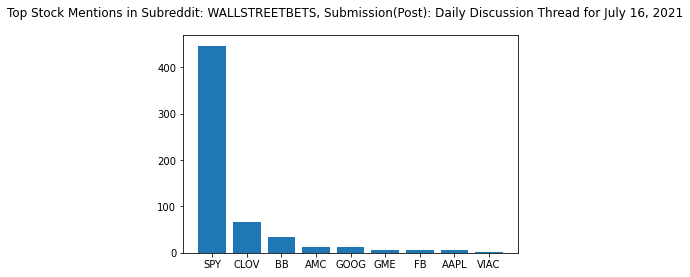

In [214]:
# Visiualising the dataframe
df_barchart_mentions = df_split.copy(deep=True)
df_barchart_mentions = df_barchart_mentions.iloc[-1, 0:]
# Dictionary with ticker as a key and mentions as a value
df_barchart_mentions = df_barchart_mentions.to_dict()

# creating the x and y values

x1 = df_barchart_mentions.keys()
y1 = df_barchart_mentions.values()

# Plotting
plt.bar(x1,y1)
plt.suptitle('Top Stock Mentions in Subreddit: {0}, Submission(Post): {1}'.format((subreddit.title).upper(), title_submission))
plt.show()

In [215]:
# Storage for all comments from the whole subreddit where regex pattern match.
regex_comments_storage = {}
more_comments_obj = {}
total_storage_of_all_comments = {}

# Creating a regex pattern object from string
pattern2 = r'($)?[vV][iI][aA][cC](om|omCBS|CBS)?'
pattern3 = r'[Aa][Mm][Cc]'

reg_exp2 = re.compile(pattern2)

In [216]:
subreddit

Subreddit(display_name='wallstreetbets')

In [225]:
# Get comments from subreddit regardless of the submission. I.e. anywhere on the subreddit. All the newest ones
# equivalent of https://www.reddit.com/r/VIAC/comments/

# Use subreddit.stream.comments() to get comments in real time.
all_recent_comments = subreddit.comments(limit=1000)

for num,comment in enumerate(all_recent_comments):
    if num == 1000:
        break
    if len(comment.body) > 4000:
        pass
    if isinstance(comment, MoreComments):
        # This should not be executed as we have converted all more comments to comments above
        print('MORE COMMENTS OBJECT!!!')
        more_comments_obj[comment.id] = comment.body
        break
    if '**User Report**' in comment.body:
        continue
    # Searching for regex pattern
    if reg_exp2.search(comment.body):
        if comment.id not in regex_comments_storage:
            print('\n {0}: {1}'.format(num,comment.body))
            regex_comments_storage[comment.id] = comment.body
        else:
            continue
    if comment.id in total_storage_of_all_comments:
        print('%d PASS. Comment already in the Dictionary' % (num))
    else:
        total_storage_of_all_comments[comment.id] = comment.body
    print('%d, %s' % (num, comment.body))


0, I sold last time at 23.80 banked some and payed off the credit cards lol
1, Can't believe how this thing continues to behave. I feel like the next 2 weeks will be better and then earnings catalyst on August 12. Lots of failures to deliver happened at the end of June on SOFI. If they haven't delivered yet I assume they will start looking to after they kill all my calls for today 🤣
2, Holy $COIN
3, $SRNE starting strong!! My dick is erected!!
4, Bro MACD indicators are so beautiful 🥵🥵
5, Are you retarded? The index has been killing it because of FAANMG and FAANMG are up like 20%
6, How many new shares?  That is also what did SPCE in - but they are issuing 500-million (a LOT)
7, bitch needs to drop 4% today
8, I have a feeling that person is gonna buy another 500k shares and its gonna go wild
9, There is no crash. The roaring 20's are upon us!
10, Cash it is then
11, SQUAREEEE LETS GO !! WAHT A BEAST!!!
12, LOL
13, Probably low volume and you bought for a bad price
14, Feeling bullish 

100, and I like it ![gif](emote|free_emotes_pack|sob)
101, Why is spy just chilling, doing nothing
102, No way 433 isn't going to hold 428 open monday
103, None of that matters if it is short dated. All that would matter is theta and the strike
104, Wow I can't believe we're chopping before OPEX, who could have predicted such a thing
105, I’d like to speak to a manager. I ordered tendies and you brought me bear poo. I ate it anyway, but I did NOT like it
106, Outstanding shares - 41.4M

Free float (publically tradable) - 21.9M

41.4 - 21.9 ~= 19.5 insider own
107, Wendy's hand job gang!
108, I've been in ALK from $40 to $70 and back. New reduced capacity guidance is a no from me dog, selling off 1/2 today, 1/2 next week even though I enjoy flying with them. Even if losses are down this earnings the guidance is gonna tank it back to the upper 40s IMO.
109, I just got chewed out by this twitter wallstreet dude who said rising interest rates don't hurt the stock market...? and said I was 

200 PASS. Comment already in the Dictionary
200, It moves too slow to ever hit those
201 PASS. Comment already in the Dictionary
201, No I didn't say it was accurate nor cheap as I have no information about that. But IF it is, it could be revolutionary.

I live in Europe, and the health care system in most countries here doesn't rely on insurance. I'm sure though, that if the device is cheap, insurance companies would likely prefer diabetics to use it.

Freestyle Libre is awesome, but expensive unless you have "free" health care, or insurance.  It costs 10x as much as a regular glucometer.
It recuires an intradermal device, which for many people who measure their blood sugar once per day would be unacceptable.

I share your scepticism, but it's important to see the market opportunity for such a product. I'm not sold on the product as the information is lacking, but for other than type 1 diabetics, this could be a big change. 

Quite a few  patients with type 2 diabetes have mangled fin

300 PASS. Comment already in the Dictionary
300, Nah, he had all those sexy cocos to nut into
301 PASS. Comment already in the Dictionary
301, SGOC ready to pump
302 PASS. Comment already in the Dictionary
302, cash gang is sleep gang
303 PASS. Comment already in the Dictionary
303, I'll probably avg down just waiting for a bottom. Their acquisition is going to give them inroads into Asia.
304 PASS. Comment already in the Dictionary
304, just gonna throw my entire paycheck in and act like today didn’t happen
305 PASS. Comment already in the Dictionary
305, its just going to go sideway right?
306 PASS. Comment already in the Dictionary
306, What is up, fellow Scotsmen? Who else scalped 0dte SPY puts today? Got to make that profit in the first hour of trading. Been a mediocre week, but today was alright. Not good enough to afford another week in this motel room, but alright. Still holding 2 x SCHW 68 puts despite trading on a SCHW-owned platform (ToS) - it looks like the market did not l

400 PASS. Comment already in the Dictionary
400, Historical indicators are good for context, but not deterministic i.e. past events and trends are not guaranteed to repeat. The world is different now.

Take your boring position to r/investing. This is a casino.
401 PASS. Comment already in the Dictionary
401, sens had a little kick. just to see if it's even breathing.
402 PASS. Comment already in the Dictionary
402, I’ve never had it but always wanted to try it, get ads for it constantly. You could def make your own version though easily and cheaper by pulverizing your own stuff and limiting what goes into it.
403 PASS. Comment already in the Dictionary
403, If T actually makes my calls not worthless I’m done. Nothing makes sense anymore. News: AT&T doesn’t suck as bad as normal. Stock goes up. What the actual fuck.
404 PASS. Comment already in the Dictionary
404, Why tf appl dropping so hard
405 PASS. Comment already in the Dictionary
405, 🚀🌓 DUK TO DA MOON🚀🌓 DUK TO DA MOON🚀🌓 DUK TO D

500 PASS. Comment already in the Dictionary
500, I’m not sure why $CLOV posts get deleted. But, I hope they are open to all the discussions and hope this won’t be discarded.

I support all the there stocks and all the three are my favorite. Right now, I think $CLOV is in a very interesting stage and looks like a good entry point to buy whether it’s a short squeeze or for a long term. And with the short squeeze perspective, $CLOV is still in the initial stages where GME was 6 months ago and AMC was 3 months ago. I think very soon $CLOV is goons explode along with $GME and $AMC.

This is totally my perspective and not a financial advice.
501 PASS. Comment already in the Dictionary
501, Brrrrr money printer man
502 PASS. Comment already in the Dictionary
502, This guy cocks
503 PASS. Comment already in the Dictionary
503, CRSR wall at $30
504 PASS. Comment already in the Dictionary
504, Took my last $2.5k and opened 430/410 put debit spreads on SPY for 8/6.

If we have a correction like s

600 PASS. Comment already in the Dictionary
600, So buy Netflix and Grubhub?
601 PASS. Comment already in the Dictionary
601, I will probably do eom and get rid of it no later than end of next week. The extra week is just a hedge in case spy decides to fuck me again.
602 PASS. Comment already in the Dictionary
602, After tacos.
603 PASS. Comment already in the Dictionary
603, Same, been buying as much as I could past 3 days  but I'm almost out of spending money lmao
604 PASS. Comment already in the Dictionary
604, Puts on JPOW
605 PASS. Comment already in the Dictionary
605, It did
606 PASS. Comment already in the Dictionary
606, Not a chance in hell the market crashes again like last time. Way too many safeguards were put in place after the last one.   
Maybe a slow bleed over the next 5-10 years. Or just stagnant prices over the same period of time.
607 PASS. Comment already in the Dictionary
607, Needs to break 300 again 🚀🚀🚀
608 PASS. Comment already in the Dictionary
608, Omg somet

700 PASS. Comment already in the Dictionary
700, You and everyone else here is this stupid
701 PASS. Comment already in the Dictionary
701, Cause he's in and wants people to pump it for him obviously.
702 PASS. Comment already in the Dictionary
702, Is there a difference between ape meme stock and VIX?
703 PASS. Comment already in the Dictionary
703, Why don't you go back to your cult of pltr
704 PASS. Comment already in the Dictionary
704, > thing I ever did is track net worth monthly

Agreed. I was living pretty budgeted, the new job affords a bit more comfortability. I'm very conscious of my spending in that regard. It's great advice.

> returns become exponential

Lol yeah fr, thank goodness for leverage and compound interest ✌️😁
705 PASS. Comment already in the Dictionary
705, I was so proud. +170% on last AMD rally. Guess where I am now.
706 PASS. Comment already in the Dictionary
706, Why the fuck is SQ green today?  


What changed for them to not be considered a trash hypergro

800 PASS. Comment already in the Dictionary
800, Spy wars is cray
801 PASS. Comment already in the Dictionary
801, I dont give a fuck what shares you hold.  I just don't like your cult.  I find you all displeasing.
802 PASS. Comment already in the Dictionary
802, Can’t wait till these WISH calls expire today I know many of us are in the same boat lol
803 PASS. Comment already in the Dictionary
803, Get those losses to 69,420 and we'll talk
804 PASS. Comment already in the Dictionary
804, QQQ 1dte, gap up for sure monday
805 PASS. Comment already in the Dictionary
805, IDEX is a steal right now
806 PASS. Comment already in the Dictionary
806, Man this week has just completely fucked me. The worst part is I had a chance to profit on every trade but woof did I choose wrong everytime. Big smooth brain here.
807 PASS. Comment already in the Dictionary
807, Yeah I just mean in terms of his name being out there. He was featured a lot and people talked about him and collabed with him more than

In [226]:
regex_comments_storage

{}

In [227]:
len(total_storage_of_all_comments.keys())

961

In [260]:
# Run through the comments in the dictionary and delete the one that exceeds the 4000 character limit

def clean_dict(dict1):
    for key, value in dict1.items():
        if len(value) > 2000:
            del dict1[key]
        else:
            pass
    
    return dict1


In [261]:
total_storage_of_all_comments = clean_dict(total_storage_of_all_comments)
len(total_storage_of_all_comments)

960

### MySQL Server connection

In [262]:
import mysql.connector
from mysql.connector import errorcode

In [263]:
# Initialising a connection with mysql server
try:
    mydb = mysql.connector.connect(user='root', 
                                   password='Blackstar5140!', 
                                   host='127.0.0.1', 
                                   database='reddit')
except errorcode.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
                                   
# creating a one cursor object to run ONE sql request
mycursor = mydb.cursor(buffered=True)

In [264]:
# Created a table.
# mycursor.execute("CREATE TABLE CommentStorage (commentId int PRIMARY KEY AUTO_INCREMENT, text varchar(4000))")
# mycursor.execute('DESCRIBE CommentStorage')
# mycursor.execute("ALTER TABLE CommentStorage ADD COLUMN comm_id_reddit VARCHAR(20)")
# mycursor.execute("ALTER TABLE CommentStorage MODIFY COLUMN text VARCHAR(2000) AFTER comm_id_reddit")

In [265]:
# Inserting data into the table CommentStorage. Looping through a database.
# Creating a copy
db_copy = total_storage_of_all_comments.copy()
for key, comment in db_copy.items():
    mycursor.execute("INSERT INTO CommentStorage (comm_id_reddit, text) VALUES (%s, %s)", (key, comment))
    
    
    
    

In [266]:
mycursor.execute("SELECT * FROM CommentStorage")

In [267]:
# mycursor.execute("DESCRIBE CommentStorage")

In [268]:
for x in mycursor:
    print(x)

(1, 'h4kvxwv', "I'll bet even if bears invented a time machine, they'd still buy puts on SPY over the last year 🤡")
(2, 'h4kvxvm', 'Alright NEGG, time to crash and burn if you will')
(3, 'h4kvxt7', 'Arigato Mr Printo')
(4, 'h4kvxqh', 'PUBM gonna make my little rocket 🍆💦')
(5, 'h4kvxhc', 'I just want PS5 :D')
(6, 'h4kvxao', 'yes.. squeeze')
(7, 'h4kvx90', 'Same. Even bought some puts just in case')
(8, 'h4kvx8a', 'Did y’all seriously not induct my boy doctorhomage yesterday??? He put 30k on 0dte tesla calls today wtf')
(9, 'h4kvx4i', "Yesterday we were down 0.8% on SP500. 0.8%. That's it, and yet the panic was so strong for a moment. Not only in WSB, which is kinda expected, but also on CNBC coverage and all over fintwit. Kinda makes me root for a real correction sometime soon. Just so it freaks out and humbles a few people")
(10, 'h4kvx0m', 'Yes likely! I don’t tie up my capital that long.')
(11, 'h4kvwsz', '“My. Dogs. Are. Hungry!”')
(12, 'h4kvwp9', 'now you can predict the market out

(1757, 'h4wgavf', '🍏150 this week!!')
(1758, 'h4wgafd', 'Gotta get that high infection before mutating into more deadly!')
(1759, 'h4wga6p', 'That would be great and as per fintel, institutional ownership is at 128.18% which is fucking ridiculous')
(1760, 'h4wg9tr', 'CLF steel gang 🦾let’s go.')
(1761, 'h4wg9o4', 'Boys oh boys I got you all rowled up ahahaha')
(1762, 'h4wg9kj', 'Bears? Nothing more bullish than a good old pandemic. 🤡👌')
(1763, 'h4wg8uw', 'But sir we only buy FDs here')
(1764, 'h4wg8m4', 'Lmao, he only did a big leap, not even an orbit')
(1765, 'h4wg8do', "While better then wealthsimple questtrade has really high trading fees especially for options. I'm switching to interactive brokers now they support Canada users")
(1766, 'h4wg89w', 'Looking at Tech futures. Jerking off. 🔪🐻🩸')
(1767, 'h4wg7vk', 'somewhere deep inside my anus just keeps enjoy losing money on tesla')
(1768, 'h4wg7oz', 'Clearly your critical thinking skills arent very sharp. \nIts the lack of competency f

In [269]:
# To commit the changes and save them in the database.
mydb.commit()

In [ ]:
#Deleting duplicate rows from the table
SELECT 
    email, COUNT(email)
FROM
    contacts
GROUP BY 
    email
HAVING 
    COUNT(email) > 1;

Next Query:
DELETE t1 FROM contacts t1
INNER JOIN contacts t2 
WHERE 
    t1.id < t2.id AND 
    t1.email = t2.email;

In [273]:
mycursor.execute("""
SELECT comm_id_reddit, COUNT(comm_id_reddit)
FROM CommentStorage
GROUP BY comm_id_reddit
HAVING COUNT(comm_id_reddit) > 1;
""")

In [274]:
mycursor.execute("""
DELETE t1 FROM CommentStorage
t1 INNER JOIN CommentStorage t2
WHERE
    t1.commentId < t2.commentId AND
    t1.comm_id_reddit = t2.comm_id_reddit
""")

DatabaseError: 1205 (HY000): Lock wait timeout exceeded; try restarting transaction

In [45]:
mycursor.execute("SELECT * FROM CommentStorage")

In [46]:
for i in mycursor:
    print(i)

(1, 'h4kvxwv', "I'll bet even if bears invented a time machine, they'd still buy puts on SPY over the last year 🤡")
(2, 'h4kvxvm', 'Alright NEGG, time to crash and burn if you will')
(3, 'h4kvxt7', 'Arigato Mr Printo')
(4, 'h4kvxqh', 'PUBM gonna make my little rocket 🍆💦')
(5, 'h4kvxhc', 'I just want PS5 :D')
(6, 'h4kvxao', 'yes.. squeeze')
(7, 'h4kvx90', 'Same. Even bought some puts just in case')
(8, 'h4kvx8a', 'Did y’all seriously not induct my boy doctorhomage yesterday??? He put 30k on 0dte tesla calls today wtf')
(9, 'h4kvx4i', "Yesterday we were down 0.8% on SP500. 0.8%. That's it, and yet the panic was so strong for a moment. Not only in WSB, which is kinda expected, but also on CNBC coverage and all over fintwit. Kinda makes me root for a real correction sometime soon. Just so it freaks out and humbles a few people")
(10, 'h4kvx0m', 'Yes likely! I don’t tie up my capital that long.')
(11, 'h4kvwsz', '“My. Dogs. Are. Hungry!”')
(12, 'h4kvwp9', 'now you can predict the market out

In [47]:
mydb.commit()

In [382]:
# Creating a new table inside existing database reddit to store TOP/HOT submissions titles
df_hot_subm = df.copy(deep=True)
df_hot_subm['author'] = df_hot_subm['author'].astype(str)
df_hot_subm[['submission_title', 'score']].loc[df_hot_subm['score'] > 10000]

,submission_title,score
5,My WSB experience so far,36954
12,Real footage of me getting ready to trade ever...,23884
70,A foolproof strategy,25961


In [311]:
df_hot_list=df_hot_subm.values.tolist()
df_hot_list

[['oldt8j',
  'Daily Discussion Thread for July 16, 2021',
  'OPINION_IS_UNPOPULAR',
  164,
  'reddit.com/r/wallstreetbets/comments/oldt8j/daily_discussion_thread_for_july_16_2021/',
  5345],
 ['oldtp9',
  'Daily Popular Tickers Thread for July 16, 2021 - AMC | GME | AAPL',
  'VisualMod',
  161,
  'reddit.com/r/wallstreetbets/comments/oldtp9/daily_popular_tickers_thread_for_july_16_2021_amc/',
  483],
 ['ole6wr',
  'These meme stock guys are a totally different breed',
  'Ratchet_as_fuck',
  3988,
  'reddit.com/r/wallstreetbets/comments/ole6wr/these_meme_stock_guys_are_a_totally_different/',
  235],
 ['olexpz',
  "We're helping",
  'xupamos87',
  902,
  'reddit.com/r/wallstreetbets/comments/olexpz/were_helping/',
  48],
 ['ol4wgi',
  'Housing crash is definitely coming and I will tell you exactly when',
  'gimegime21',
  8432,
  'reddit.com/r/wallstreetbets/comments/ol4wgi/housing_crash_is_definitely_coming_and_i_will/',
  774],
 ['okyjq5',
  'My WSB experience so far',
  'future_me202

In [306]:
#mycursor.execute("CREATE TABLE Submissions (id int PRIMARY KEY AUTO_INCREMENT, submission_id VARCHAR(20), submission_title VARCHAR(2000), author VARCHAR(150), score int, link VARCHAR(2000), comments int)")


In [313]:
# Inserting submissions data into the reddit.submissions table
for list_list in df_hot_list:
    submission_id = list_list[0]
    submission_title = list_list[1]
    author = list_list[2]
    score = list_list[3]
    link = list_list[4]
    comments = list_list[5]
    mycursor.execute("INSERT INTO reddit.Submissions (submission_id, submission_title, author, score, link, comments) VALUES (%s, %s, %s, %s, %s, %s)", (str(submission_id), str(submission_title), str(author), int(score), str(link), int(comments)))






In [314]:
mycursor.execute('SELECT * FROM reddit.Submissions')

In [315]:
for i in mycursor:
    print(i)

(1, 'oldt8j', 'Daily Discussion Thread for July 16, 2021', 'OPINION_IS_UNPOPULAR', 164, 'reddit.com/r/wallstreetbets/comments/oldt8j/daily_discussion_thread_for_july_16_2021/', 5345)
(2, 'oldtp9', 'Daily Popular Tickers Thread for July 16, 2021 - AMC | GME | AAPL', 'VisualMod', 161, 'reddit.com/r/wallstreetbets/comments/oldtp9/daily_popular_tickers_thread_for_july_16_2021_amc/', 483)
(3, 'ole6wr', 'These meme stock guys are a totally different breed', 'Ratchet_as_fuck', 3988, 'reddit.com/r/wallstreetbets/comments/ole6wr/these_meme_stock_guys_are_a_totally_different/', 235)
(4, 'olexpz', "We're helping", 'xupamos87', 902, 'reddit.com/r/wallstreetbets/comments/olexpz/were_helping/', 48)
(5, 'ol4wgi', 'Housing crash is definitely coming and I will tell you exactly when', 'gimegime21', 8432, 'reddit.com/r/wallstreetbets/comments/ol4wgi/housing_crash_is_definitely_coming_and_i_will/', 774)
(6, 'okyjq5', 'My WSB experience so far', 'future_me2020', 36954, 'reddit.com/r/wallstreetbets/comment

In [316]:
mydb.commit()

In [317]:
# To close connection with the MYSQL server. After this line, you can't call requests to Mysql Server
mydb.close()

# Wrapping the application into a Jupyter Notebook Program with Widgets

In [319]:
# Importing Jupyter Notebook widgets to create a interactive GUI.
import ipywidgets as widgets

# To display widgets on demand
from IPython.display import display

In [142]:
a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')
def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

In [541]:
##  Function to extract comments from a submission and store it in the dictionary
def comments_to_submission_id_(sub_id):
    # Local Dictionary
    dict_subm = {}
    # Accessing the submission via reddit.submission method
    example_submission = reddit.submission(id=sub_id)
    # Sorting all comments in the submission by newest first
    example_submission.comment_sort = 'new'

    # Flattening the forrest comment to same level (No more top level and replies level comments)
    # Also Replacing More Comments objects with Comments objects themselves.
    example_submission.comments.replace_more(limit=None)

    all_comments = example_submission.comments.list()

    # Check uniqueness of each comment
    comment_done = set()

    # In the Praw docs it states that these MoreComments objects are a representation 
    # of the load more comments and continue this thread links encountered on Reddit.
    # To solve this issue so it loads all the comments and don't get stuck on MoreComments object
    for comment in all_comments:
        if isinstance(comment, MoreComments):
            # This should not be executed as we have converted all more comments to comments above
            continue
        if '**User Report**' in comment.body:
            continue
        if len(comment.body) > 2 and comment.id not in comment_done:
            if sub_id not in dict_subm:
                #print(comment.body)
                comment_done.add(comment.id)
                dict_subm[sub_id] = [comment.body]
            else:
                #print(comment.body)
                dict_subm[sub_id].append(comment.body)
    print('Extraction Comepleted!')
    print('Total number of comments extracted: %d' % (len(dict_subm[sub_id])))
    
    return dict_subm

In [549]:
## Widgets Final Build

# Functions
def subreddit_generator(val):
    subr1 = reddit.subreddit(val)
    return subr1

def submissions_generator(subreddit1):
    subms = subreddit1.hot(limit=25)
    sub_storage = []
    
    # Dictionary storage of submission_id and submission_title
    subm_id_dict = {}
    
    for sub in subms:
        sub_storage.append(sub.title)
        subm_id_dict[sub.title] = sub.id
        
    return sub_storage, subm_id_dict
        

# Function for a button onclick
def generate_subreddit(input_val):
    val = input_val
    try:
        subr11 = subreddit_generator(val)
        print("Successfully located subreddit: {}".format(subr11.title))
        subms = submissions_generator(subr11)[0]
        submission_title.options = subms
    except ValueError:
        print("Subreddit name cannot be empty! Please try again")
    except Exception as e:
        print("Please provide a real subreddit")


def posts_visualiser(submission, regex_pattern):

    if regex_pattern == '':
        raise Exception("No Value was passed in the parameter. Please input a regex pattern")
    
    with output_main:
        print(submission.value, regex_pattern)

def button_disabler(txt):
    # Checking that there was a change made to the widget's input
    if txt == "":
        posts_generate_button.disabled = True
    else:
        posts_generate_button.disabled = False

def _generate_comments(regex_pat):
    subm_label = submission_title
    # display title of the selected submmission
    subm_label = subm_label.label
    
    subr_name = subreddit_input.value
    subr_object = subreddit_generator(subr_name)
    subms_id_storage = submissions_generator(subr_object)[1]
    
    # get the subm id for the selected subm title
    sub_id = subms_id_storage[subm_label]
    
    # get the actual submission object
    #submission_object = reddit.submission(id=sub_id)
    
    # Get the submission object and from it you get a dictionary of comments.
    dictionary_comments_storage = comments_to_submission_id_(sub_id)
    
    # Creating a dataframe with comments to analyse further
    df_comments = pd.DataFrame(data=dictionary_comments_storage)
    df_comments.columns = ['Comments']
    df_comments = df_comments['Comments'].astype(str)
    # Converting a Series back to DataFrame
    df_comments = df_comments.to_frame()
    
    # Testing each comment with regex whether it contains the pattern searched
    df_test1 = df_comments.copy(deep=True)

    # The pattern is correct. The warning appearing at the bottom is misleading.
    #pattern2 = r'($)?[vV][iI][aA][cC](om|omCBS|CBS)?'
    #pattern3 = r'[Aa][Mm][Cc]'

    regex_pat = str(regex_pat)
    
    check_t_df = df_test1.loc[df_test1['Comments'].str.contains(pat=regex_pat, regex=True, case=False)].reset_index(drop=True)
    check_t_df = check_t_df['Comments'].to_list()
    
    return print(check_t_df)
        
def plot_graph(b):

    return _generate_comments(regex_pattern.value)
    
    
    
    
# Global variables
dictionary_comments_storage = {}
        
# Defining widgets
subreddit_input = widgets.Text(
    #value='',
    placeholder='Please input the name',
    description='Subreddit:',
    disabled=False,
)

posts_generate_button = widgets.Button(
    description='Analyse Submissions',
    disabled=True,
    #button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Analyse Submissions for given regex pattern',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

submission_title = widgets.Dropdown(
    options=['Title of the submission'],
    description='Submissions (Hot 25)',
    disabled=False,
)

regex_pattern = widgets.Text(
    #value='',
    placeholder='Please input the REGEX pattern',
    description='This pattern will be searched for in each comment',
    disabled=False,    
)

# Output widget
output_main = widgets.Output(layout={'border': '1px solid black'})

# Visualise a graph
posts_generate_button.on_click(plot_graph)

widgets.interact_manual(generate_subreddit, input_val=subreddit_input)
display(submission_title)
widgets.interact(button_disabler, txt=regex_pattern)
display(posts_generate_button)

output_main

interactive(children=(Text(value='', description='Subreddit:', placeholder='Please input the name'), Button(de…

Dropdown(description='Submissions (Hot 25)', options=('Title of the submission',), value='Title of the submiss…

interactive(children=(Text(value='', description='This pattern will be searched for in each comment', placehol…

Button(description='Analyse Submissions', disabled=True, style=ButtonStyle(), tooltip='Analyse Submissions for…

Output(layout=Layout(border='1px solid black'))

In [430]:
subr11 = subreddit_generator(subreddit_input.value)
(subr11)

Subreddit(display_name='wallstreetbets')

In [431]:
a1 = subreddit_generator(subreddit_input.value)
submissions_generator(a1)

['Weekend Discussion Thread for the Weekend of July 16, 2021',
 'My kids are fucked.',
 '$TSLA Fud',
 'It really do be like that sometimes',
 'The Excitement of Theta Gang',
 'this is the way?',
 'Escalator Up Elevator Down!',
 'This is so stupid; I wanna exercise my calls and buy 300 shares for $800 each, but it’s telling me i’m not allowed to.. Anyone here retarded enough to help me out?',
 'When you gamble your entire 401k into one meme stock...',
 '$1.2MM AvePoint (AVPT) Yolo!']

In [180]:
subreddit_input.value

'wallstreetbets'

In [393]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print(change['new'])

int_range.observe(on_value_change, names='value')

IntSlider(value=0)

Output()

In [388]:
w = widgets.Dropdown(
    options=['Addition', 'Multiplication', 'Subtraction', 'Division'],
    value='Addition',
    description='Task:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='Task:', options=('Addition', 'Multiplication', 'Subtraction', 'Division'), value='Additi…

changed to Multiplication
changed to Division
changed to Multiplication
changed to Division
changed to Addition
changed to Multiplication


In [390]:
geo={'USA':['CHI','NYC'],'Russia':['MOW','LED']}

def print_city(city):
    print(city)

def select_city(country):
    cityW.options = geo[country]


scW = widgets.Select(options=geo.keys())
init = scW.value
cityW = widgets.Select(options=geo[init])
j = widgets.interactive(print_city, city=cityW)
i = widgets.interactive(select_city, country=scW)
display(i)
display(j)

interactive(children=(Select(description='country', options=('USA', 'Russia'), value='USA'), Output()), _dom_c…

interactive(children=(Select(description='city', options=('CHI', 'NYC'), value='CHI'), Output()), _dom_classes…

In [391]:
geo={'USA':['CHI','NYC'],'Russia':['MOW','LED']}

def main_function(city, country):
    print (f'{city} is a city in {country}')
    cityW.options = geo[country]    

scW = widgets.Select(options=geo.keys())
cityW = widgets.Select(options=geo[init])

widgets.interactive(main_function, city=cityW, country=scW)

interactive(children=(Select(description='city', options=('CHI', 'NYC'), value='CHI'), Select(description='cou…

In [435]:
def dropdown_eventhandler(change):
    print(change.new)

option_list = (1, 2, 3)
dropdown = widgets.Dropdown(description="Choose one:", options=option_list)
dropdown.observe(dropdown_eventhandler, names='value')
display(dropdown)

Dropdown(description='Choose one:', options=(1, 2, 3), value=1)

2
3


In [437]:
def f(x):
    return x

widgets.interact(f, x=10);


interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [439]:
def f(a, b):
    display(a + b)
    return a+b

w = widgets.interactive(f, a=10, b=20)
display(w)


interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

In [442]:
x_widget = widgets.FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = widgets.FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
widgets.interact(printer,x=x_widget, y=y_widget);

interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, step=0.05), FloatSlider(value=5.0, des…

In [461]:
w1 = widgets.Text(value="Nikita")
w2 = widgets.Text(value="ViacomCBS")

def textmerge(txt1, txt2):
    return txt1 + txt2
widgets.interact_manual(textmerge, txt1=w1, txt2=w2)

interactive(children=(Text(value='Nikita', description='txt1'), Text(value='ViacomCBS', description='txt2'), B…

<function __main__.textmerge(txt1, txt2)>

In [453]:
def slow_function(i):
    print(int(i),list(x for x in range(int(i)) if
                str(x)==str(x)[::-1] and
                str(x**2)==str(x**2)[::-1]))
    return

widgets.interact_manual(slow_function,i=widgets.FloatSlider(min=1e5, max=1e7, step=1e5));


interactive(children=(FloatSlider(value=100000.0, description='i', max=10000000.0, min=100000.0, step=100000.0…

In [458]:
widgets.interact_manual(options='name')

In [511]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print(change['new'])

int_range.observe(on_value_change, names='value')

IntSlider(value=0)

Output()